Importing Required Packages

In [1560]:
import numpy as np
import pandas as pd
import functools

<h1>Data Cleaning and Understanding</h1>

**Reading CSV files.**
I could see that some companies having non-ascii characters in their name, and the provided underlaying CSV files were stored with ANSI encodig, thus I needed to again save it with utf-8 encoding.

In [1561]:
companies = pd.read_csv("companies.csv", encoding = "utf-8")
rounds2 = pd.read_csv("rounds2.csv", encoding = "utf-8")

**We could see that some entries of "Permalink" attribute is in upper case while some in lowerer case.
So making them uniform before counting unique number of companies.**

In [1562]:
rounds2.company_permalink = rounds2.company_permalink.apply(lambda x: x.lower())

In [1563]:
rounds2.company_permalink.nunique()

66368

In [1564]:
companies.permalink = companies.permalink.apply(lambda x: x.lower())

In [1565]:
companies.permalink.nunique()

66368

**Q: Are there any companies in the rounds2 file which are not  present in companies?**

In [1566]:
companiesInRounds2 = set(rounds2.company_permalink)
companiesInCompanies = set(companies.permalink)

In [1567]:
inRounds2NotInCompanies = companiesInRounds2.difference(companiesInCompanies)
inCompaniesNotInRounds2 = companiesInCompanies.difference(companiesInRounds2)
print(inRounds2NotInCompanies)
print(inCompaniesNotInRounds2)

set()
set()


<h3>Analysing the data in both the Dataframes</h3>

**Checking existing variables in the dataframes**

In [1568]:
rounds2.head(1)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0


In [1569]:
companies.head(1)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN


**Renaming the column 'company_permalink' to 'permalink', so it can be used in merging the dataframesm**

In [1570]:
rounds2 = rounds2.rename(columns={'company_permalink': 'permalink'})


**Merging both Dataframes togather and forming Master dataframe**

In [1571]:
master_frame = pd.merge(left = rounds2, right = companies, how ="left", on ="permalink")

**How many observations are present in master_frame?**

In [1572]:
print("Unique observations in Master dataframe:",master_frame.funding_round_permalink.nunique())

Unique observations in Master dataframe: 114949


<h3>Data Cleaning</h3>

**Checking for duplicate rows**

In [1573]:
print("Overall Rows in Master dataframe:", master_frame.shape[0])
print("Unique Funding permalinks in Master dataframe:",master_frame.funding_round_permalink.nunique())

Overall Rows in Master dataframe: 114949
Unique Funding permalinks in Master dataframe: 114949


**Checking for missing values**

In [1574]:
print("Missing values in rows for Raised Fund", master_frame[np.isnan(master_frame.raised_amount_usd)].shape[0])
print("Missing values in rows for Fund type", master_frame[master_frame.funding_round_type == ""].shape[0])
print("Missing values in rows for Contry code", master_frame[master_frame.country_code == ""].shape[0])

Missing values in rows for Raised Fund 19990
Missing values in rows for Fund type 0
Missing values in rows for Contry code 0


In [1575]:
#cheching the sum of raised fund for all type of status to see if any status is being inactive or not
master_frame.groupby(['status']).sum()

,raised_amount_usd
status,
acquired,1.355237e+11
closed,5.353049e+10
ipo,2.099612e+11
operating,5.911097e+11


**Dropping unnecessay columns**

In [1576]:
master_frame = master_frame.drop(['funded_at',  'funding_round_code','homepage_url', 'state_code', 'region', 'city', 'founded_at'], axis = 1)

<h3>We know that "Spark Funds wants to choose one of four (venture, angel, seed, and private equity) investment types for each potential investment they will make."</h3>

**Filtering the dataset with these four types only**

In [1577]:
considerFundTypeList = ['venture', 'angel', 'seed','private_equity']
master_frame = master_frame[master_frame.funding_round_type.isin(considerFundTypeList)]                           

**checking general distrubution of the 'Raised_amount_usd' in different fund types**

In [1623]:
def plotBoxPlotForMasterDataframe():
    fundForTypes = []
    
    fundForTypes.append(master_frame[master_frame.funding_round_type == 'venture'].raised_amount_usd)
    fundForTypes.append(master_frame[master_frame.funding_round_type == 'angel'].raised_amount_usd)
    fundForTypes.append(master_frame[master_frame.funding_round_type == 'seed'].raised_amount_usd)
    fundForTypes.append(master_frame[master_frame.funding_round_type == 'private_equity'].raised_amount_usd)
  
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    
    plotDF = functools.reduce(lambda a,b : pd.concat([a,b], axis = 1), fundForTypes)
    plotDF.columns = ['venture', 'angel', 'seed', 'private_equity' ]
    
    plotDF.boxplot(column=['venture'], ax = ax[0][0])
    plotDF.boxplot(column=['angel'], ax = ax[0][1])
    plotDF.boxplot(column=['seed'], ax = ax[1][0])
    plotDF.boxplot(column=['private_equity'], ax = ax[1][1])
    
    plt.show()
    

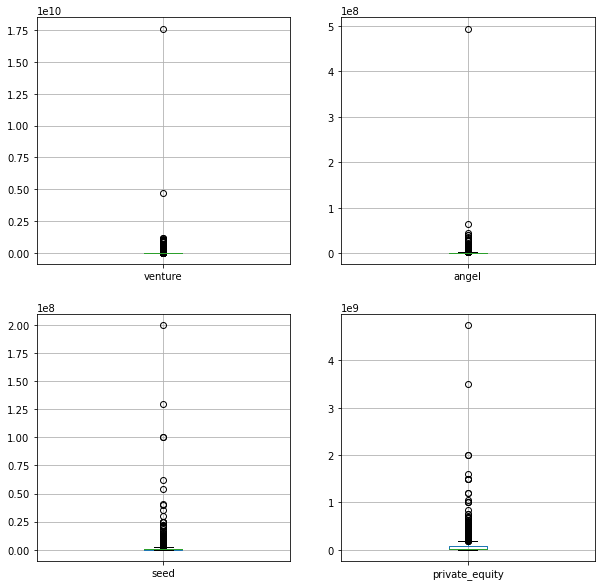

In [1579]:
plotBoxPlotForMasterDataframe()

<h3>Replacing the 'Nan' values for 'raised_amount_usd' with median values and remove outliers (above 95th Percentile) for respective funding round type</h3>

Segmenting the master dataframe into sub data frame based on the fund type

* We will set the median value of raised fund where it is missing
* We will remove the outliers

In [1580]:
listOfTempDF = []

#We can ignore the "SettingWithCopyWarning:" warning as we anyways dont need to refect the change on master dataframe.
#We will re-create the master data frame by concating the sub data frames.
for ty in fundByRoundType.index:
    df = master_frame[master_frame.funding_round_type == ty]
    
    medianFundVal = df.raised_amount_usd.median()
    nintyFifthPer = df.raised_amount_usd.quantile(.95)
    
    df.raised_amount_usd = df.raised_amount_usd.apply(lambda x: x if ~np.isnan(x) else medianFundVal)
    df = df[df.raised_amount_usd <= nintyFifthPer]
    
    listOfTempDF.append(df)

#concating all segmented data frames back and forming a single master data frame.
master_frame = functools.reduce(lambda a,b : pd.concat([a,b]), listOfTempDF)




E:\Users\amitkumar.maheshwari\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
E:\Users\amitkumar.maheshwari\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
E:\Users\amitkumar.maheshwari\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

**Lets check distribution of Raised Fund, Fund Type wise**

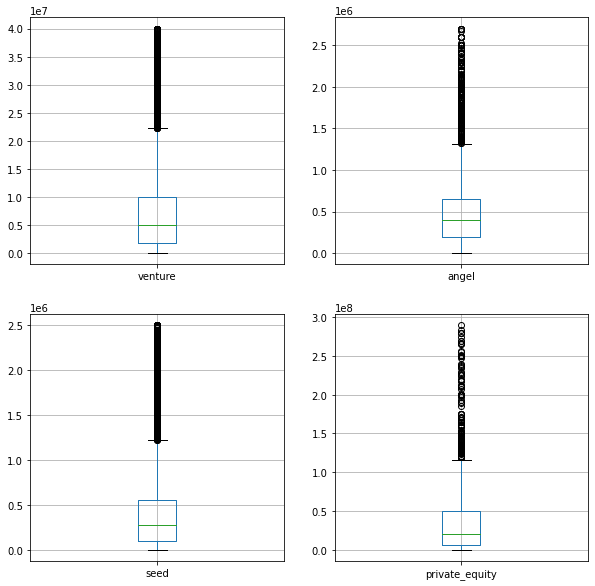

In [1581]:
plotBoxPlotForMasterDataframe()

<h3>Q: Representative funding amount of of different types</h3>

To find Representative, using median of respective funding type values

In [1582]:
fundByRoundType  = master_frame.groupby(['funding_round_type']).median()
fundByRoundType.head(20)

,raised_amount_usd
funding_round_type,
angel,400000.0
private_equity,20000000.0
seed,275000.0
venture,5000000.0


**Q: Considering that Spark Funds wants to invest between 5 to 15 million USD per investment round, which investment type is the most suitable for them?**

In [1583]:
fundBetween5To15M = fundByRoundType[(fundByRoundType.raised_amount_usd >= 5000000) & (fundByRoundType.raised_amount_usd <= 15000000)]
fundBetween5To15M.head(4)

,raised_amount_usd
funding_round_type,
venture,5000000.0


**Spark Funds wants to see the top nine countries which have received the highest total funding**

In [1584]:
top9 = master_frame.groupby(['country_code']).sum().sort_values(by=['raised_amount_usd'], ascending = False).head(9)
top9

,raised_amount_usd
country_code,
USA,3.424035e+11
GBR,2.065567e+10
CHN,1.940669e+10
CAN,1.149112e+10
IND,1.137514e+10
ISR,7.863702e+09
DEU,7.051244e+09
FRA,6.877607e+09
CHE,3.088564e+09


To Identifying Top 3 english speaking countries from the "Top9" countries,
we can refer to this https://en.wikipedia.org/wiki/List_of_countries_and_territories_where_English_is_an_official_language

Making a sample english speaking country's list (one can obtain full list from above link) and fetch top 3 from "Top9"

In [1585]:
EnglishSpeaking = ['AUS', "USA", "GBR", "CAN", "IND", "NZL"]
top3 = top9[top9.index.isin(EnglishSpeaking)].head(3)
top3

,raised_amount_usd
country_code,
USA,3.424035e+11
GBR,2.065567e+10
CAN,1.149112e+10


<h3>Now further analysis will be done only for these three countries and 'venture' type investment, on seperate dataframes segemented contry wise. </h3>
D1 - USA

D2 - GBR

D3 - CAN

In [1586]:
d1 = master_frame[(master_frame.country_code == 'USA') & (master_frame.funding_round_type == 'venture')]
d2 = master_frame[(master_frame.country_code == 'GBR') & (master_frame.funding_round_type == 'venture')]
d3 = master_frame[(master_frame.country_code == 'CAN') & (master_frame.funding_round_type == 'venture')]
print(d1.shape)
print(d2.shape)
print(d3.shape)

(36825, 8)
(2236, 8)
(1324, 8)


**In Top 3 countrie's dataframe, Deriving Primary Category variable from category variable**

In [1587]:
d1['primary_category'] = d1.category_list.apply(lambda x : x.split("|")[0] if (x == x) else x)
d2['primary_category'] = d2.category_list.apply(lambda x : x.split("|")[0] if (x == x) else x)
d3['primary_category'] = d3.category_list.apply(lambda x : x.split("|")[0] if (x == x) else x)

<ipython-input-1587-08ea345bb506>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1['primary_category'] = d1.category_list.apply(lambda x : x.split("|")[0] if (x == x) else x)
<ipython-input-1587-08ea345bb506>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d2['primary_category'] = d2.category_list.apply(lambda x : x.split("|")[0] if (x == x) else x)
<ipython-input-1587-08ea345bb506>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

<h3>Mapping Table : Reading and cleaning data </h3>
Reading 'mapping' file

In [1588]:
mapping = pd.read_csv("mapping.csv")
mapping.head(4)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0


<h4> Data Cleaning for Mapping Dataframe</h4>

**Removing 'Nan' Category from mapping**

In [1589]:
print(mapping.shape)
mapping = mapping[mapping.category_list == mapping.category_list]
print(mapping.shape)

(688, 10)
(687, 10)


**We could see in the category list that if a character '0' comes in between of any category value, that is misplaced with 'na'**

Thus correcting it

In [1590]:
mapping.category_list = mapping.category_list.apply(lambda x: x.replace("0", "na") if ~x.endswith("0") else x)

**Deriving new column 'Sector' into mapping table that will have name of the main sector in which perticular category falls**

In [1591]:
sectorList = ['Automotive & Sports','Blanks','Cleantech / Semiconductors','Entertainment','Health','Manufacturing','News, Search and Messaging','Others', 'Social, Finance, Analytics, Advertising']

In [1592]:
mapping['Sector'] = mapping.category_list.apply(lambda x: sectorList[mapping[mapping.category_list == x].iloc[0].tolist().index(1) - 1])

**Removing unnecessary columns from mapping table**

In [1593]:
mapping = mapping.drop(sectorList, axis = 1)


**Renaming the column of Mapping from 'category_list' to 'primary_category'**

In [1594]:
mapping = mapping.rename(columns={'category_list': 'primary_category'})

<h2>Merging Mapping table into Top 3 contries dataframes (d1, d2, d3)</h2>

In [1595]:
#master_frame = pd.merge(left = rounds2, right = companies, how ="outer", on ="primary_category")
d1 = pd.merge(left = d1, right = mapping, how = "left", on = "primary_category")
d2 = pd.merge(left = d2, right = mapping, how = "left", on = "primary_category")
d3 = pd.merge(left = d3, right = mapping, how = "left", on = "primary_category")

<h1>Sector-wise Investment Analysis</h1>

 1. Total number of investments (count)

In [1596]:
print("Country 1- Total Number  of investemt:", d1.shape[0])
print("Country 2- Total Number  of investemt:", d2.shape[0])
print("Country 3- Total Number  of investemt:", d3.shape[0])

Country 1- Total Number  of investemt: 36825
Country 2- Total Number  of investemt: 2236
Country 3- Total Number  of investemt: 1324


2. Total amount of investment (USD)

In [1597]:
print("Country 1- Total amount  of investemt:", d1.raised_amount_usd.sum())
print("Country 2- Total amount  of investemt:", d2.raised_amount_usd.sum())
print("Country 3- Total amount  of investemt:", d3.raised_amount_usd.sum())

Country 1- Total amount  of investemt: 278550479398.0
Country 2- Total amount  of investemt: 15414461732.0
Country 3- Total amount  of investemt: 8507730301.0


 3. Top sector (based on count of investments)

In [1598]:
d1.Sector.value_counts()

Others                                     8485
Cleantech / Semiconductors                 7649
Social, Finance, Analytics, Advertising    7520
News, Search and Messaging                 4445
Health                                     3296
Manufacturing                              2546
Entertainment                              1864
Automotive & Sports                         531
Name: Sector, dtype: int64

In [1599]:
print("Country 1- Top sector (based on count of investments):", d1.Sector.value_counts().index[0])
print("Country 2- Top sector (based on count of investments):", d2.Sector.value_counts().index[0])
print("Country 3- Top sector (based on count of investments):", d3.Sector.value_counts().index[0])


Country 1- Top sector (based on count of investments): Others
Country 2- Top sector (based on count of investments): Others
Country 3- Top sector (based on count of investments): Cleantech / Semiconductors


4. Second-best sector (based on count of investments)

In [1600]:
print("Country 1- Second-best sector (based on count of investments):", d1.Sector.value_counts().index[1])
print("Country 2- Second-best sector (based on count of investments):", d2.Sector.value_counts().index[1])
print("Country 3- Second-best sector (based on count of investments):", d3.Sector.value_counts().index[1])

Country 1- Second-best sector (based on count of investments): Cleantech / Semiconductors
Country 2- Second-best sector (based on count of investments): Social, Finance, Analytics, Advertising
Country 3- Second-best sector (based on count of investments): Others


 5. Third-best sector (based on count of investments)

In [1601]:
print("Country 1- Third-best sector (based on count of investments):", d1.Sector.value_counts().index[2])
print("Country 2- Third-best sector (based on count of investments):", d2.Sector.value_counts().index[2])
print("Country 3- Third-best sector (based on count of investments):", d3.Sector.value_counts().index[2])

Country 1- Third-best sector (based on count of investments): Social, Finance, Analytics, Advertising
Country 2- Third-best sector (based on count of investments): Cleantech / Semiconductors
Country 3- Third-best sector (based on count of investments): Social, Finance, Analytics, Advertising


 6. Number of investments in the top sector (refer to point 3)

In [1602]:
print("Country 1- Top sector Number of investments:", d1.Sector.value_counts()[0])
print("Country 2- Top sector Number of investments:", d2.Sector.value_counts()[0])
print("Country 3- Top sector Number of investments:", d3.Sector.value_counts()[0])

Country 1- Top sector Number of investments: 8485
Country 2- Top sector Number of investments: 564
Country 3- Top sector Number of investments: 341


 7. Number of investments in the second-best sector (refer to point 4)

In [1603]:
print("Country 1- Second-best sector Number of investments:", d1.Sector.value_counts()[1])
print("Country 2- Second-best sector Number of investments:", d2.Sector.value_counts()[1])
print("Country 3- Second-best sector Number of investments:", d3.Sector.value_counts()[1])

Country 1- Second-best sector Number of investments: 7649
Country 2- Second-best sector Number of investments: 464
Country 3- Second-best sector Number of investments: 333


 8. Number of investments in the third-best sector (refer to point 5)

In [1604]:
print("Country 1- Third-best sector Number of investments:", d1.Sector.value_counts()[2])
print("Country 2- Third-best sector Number of investments:", d2.Sector.value_counts()[2])
print("Country 3- Third-best sector Number of investments:", d3.Sector.value_counts()[2])

Country 1- Third-best sector Number of investments: 7520
Country 2- Third-best sector Number of investments: 443
Country 3- Third-best sector Number of investments: 237


 9. For the top sector count-wise (point 3), which company received the highest investment?

In [1605]:
print("Country 1 - Top Secotor - Highest paid company", list(d1[d1.Sector == 'Social, Finance, Analytics, Advertising'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
print("Country 2 - Top Secotor - Highest paid company", list(d2[d1.Sector == 'Social, Finance, Analytics, Advertising'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
print("Country 2 - Top Secotor - Highest paid company", list(d3[d1.Sector == 'Others'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])

Country 1 - Top Secotor - Highest paid company Undertone
Country 2 - Top Secotor - Highest paid company HouseTrip
Country 2 - Top Secotor - Highest paid company Kik


<ipython-input-1605-4805e25f3e7f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Country 2 - Top Secotor - Highest paid company", list(d2[d1.Sector == 'Social, Finance, Analytics, Advertising'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
<ipython-input-1605-4805e25f3e7f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Country 2 - Top Secotor - Highest paid company", list(d3[d1.Sector == 'Others'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])


 10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [1606]:
print("Country 1 - second-best Secotor - Highest paid company", list(d1[d1.Sector == 'Others'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
print("Country 2 - second-best Secotor - Highest paid company", list(d2[d1.Sector == 'Others'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
print("Country 2 - second-best Secotor - Highest paid company", list(d3[d1.Sector == 'Social, Finance, Analytics, Advertising'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])

Country 1 - second-best Secotor - Highest paid company LifeLock
Country 2 - second-best Secotor - Highest paid company Atom Bank
Country 2 - second-best Secotor - Highest paid company Skyline International Development


<ipython-input-1606-b8c5fe3000aa>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Country 2 - second-best Secotor - Highest paid company", list(d2[d1.Sector == 'Others'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])
<ipython-input-1606-b8c5fe3000aa>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Country 2 - second-best Secotor - Highest paid company", list(d3[d1.Sector == 'Social, Finance, Analytics, Advertising'].sort_values(by=['raised_amount_usd'], ascending=False).head(1)['name'])[0])


<h1>Charts</h1>

**A plot showing the representative amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.**   

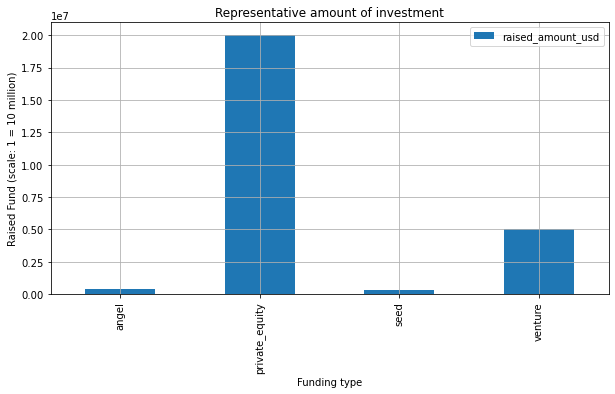

In [1620]:
fundByRoundType.plot(kind = 'bar', figsize=(10,5), grid = True)
plt.title("Representative amount of investment")
plt.xlabel("Funding type")
plt.ylabel("Raised Fund (scale: 1 = 10 million)")
plt.show()


**Fund Type wise gernal distribution Riased amount**

Boxplots will not only show 25th and 75th percentile, but also show median

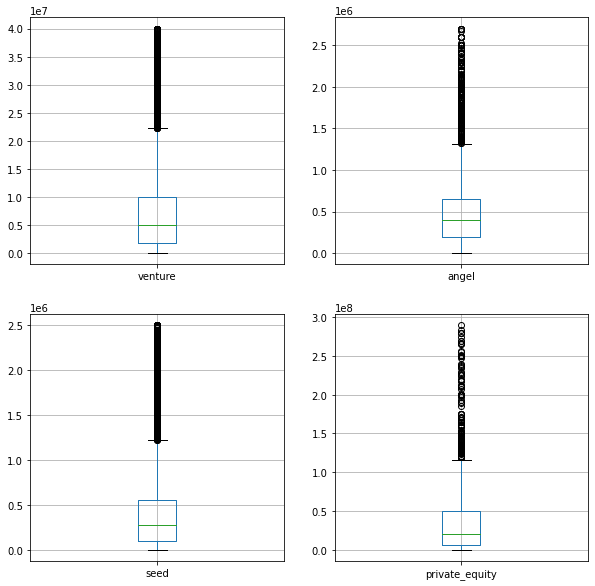

In [1622]:
plotBoxPlotForMasterDataframe()

**A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.**    

Overall Funding

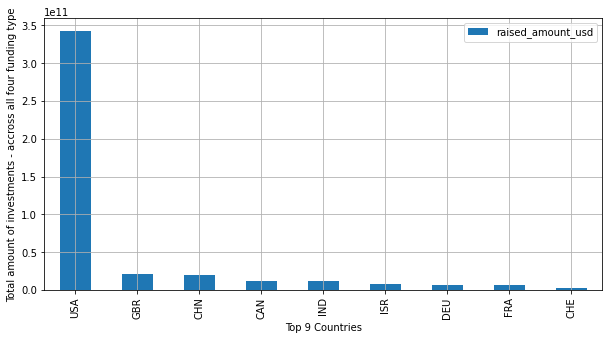

In [1624]:
top9.plot(kind = 'bar',figsize=(10,5), grid = True)
plt.xlabel("Top 9 Countries")
plt.ylabel("Total amount of investments - accross all four funding type")


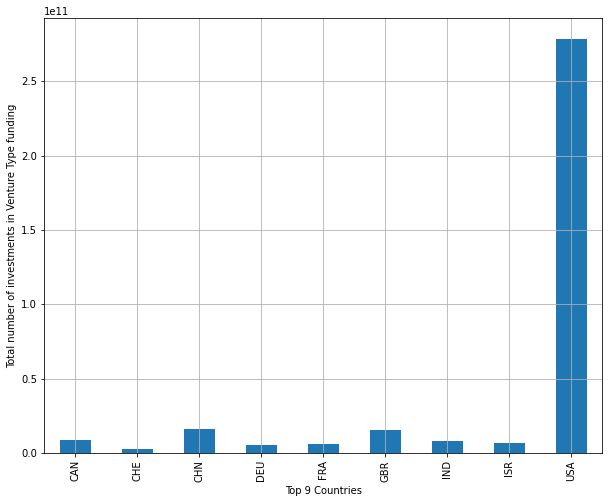

In [1625]:
top9CounryVentureData = master_frame[(master_frame.funding_round_type == "venture") & master_frame.country_code.isin(list(top9.index))]
top9CounryVentureData.groupby(['country_code']).sum()['raised_amount_usd'].plot(kind = 'bar',figsize=(10,8), grid = True)
plt.xlabel("Top 9 Countries")
plt.ylabel("Total number of investments in Venture Type funding")

Funding in 'Venture' Type

**A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). This plot should clearly display the top 3 sectors each in Country 1, Country 2, and Country 3.**

In [1627]:
topSectorsInUSA = d1[d1.Sector.isin(['Social, Finance, Analytics, Advertising', 'Others', 'Cleantech / Semiconductors'])]
topSectorsInGBR = d2[d2.Sector.isin(['Social, Finance, Analytics, Advertising', 'Others', 'Cleantech / Semiconductors'])]
topSectorsInCAN = d3[d3.Sector.isin(['Others', 'Social, Finance, Analytics, Advertising', 'Cleantech / Semiconductors'])]

In [1628]:
topSecInTop3Cont = pd.concat([topSectorsInUSA, topSectorsInGBR, topSectorsInCAN])
topSecInTop3Cont = topSecInTop3Cont.drop(['permalink', 'funding_round_permalink', 'raised_amount_usd', 'name', 'category_list', 'status', 'primary_category'], axis = 1)
topSecInTop3Cont

,funding_round_type,country_code,Sector
1,venture,USA,Others
2,venture,USA,"Social, Finance, Analytics, Advertising"
3,venture,USA,"Social, Finance, Analytics, Advertising"
4,venture,USA,"Social, Finance, Analytics, Advertising"
13,venture,USA,"Social, Finance, Analytics, Advertising"
...,...,...,...
1319,venture,CAN,Cleantech / Semiconductors
1320,venture,CAN,Cleantech / Semiconductors
1321,venture,CAN,Cleantech / Semiconductors
1322,venture,CAN,Cleantech / Semiconductors


In [1629]:
pTabTopSecInTop3Cont = pd.pivot_table(topSecInTop3Cont, index=['funding_round_type', 'Sector'],
                    columns=['country_code'], aggfunc= lambda x: len(x))
pTabTopSecInTop3Cont

country_code                                                CAN  GBR   USA
funding_round_type Sector                                                 
venture            Cleantech / Semiconductors               341  443  7649
                   Others                                   333  564  8485
                   Social, Finance, Analytics, Advertising  237  464  7520

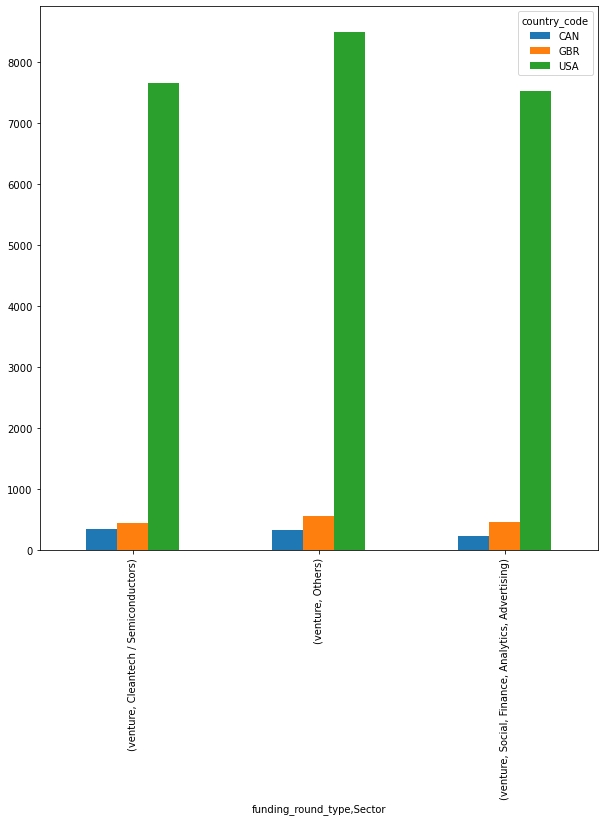

In [1632]:
#pTabTopSecInTop3Cont[ventureType].plot(kind = 'bar', figsize=(10,10))
pTabTopSecInTop3Cont.plot(kind = 'bar', figsize=(10,10))